In [1]:
import arviz
import pandas as pd
from model_builder import ModelBuilder
from posteriorplots import predictive_plot, retrodictive_plot

In [2]:
arviz.style.use("arviz-darkgrid")

In [3]:
%load_ext autoreload
%autoreload 2

## Model with socio-eco predictors

- https://fivethirtyeight.com/features/how-fivethirtyeights-2020-presidential-forecast-works-and-whats-different-because-of-covid-19/
-    Jobs, as indicated by nonfarm payrolls.
    Spending, as indicated by real personal consumption expenditures.
    Income, as measured by real disposable personal income.
    Manufacturing, as measured by industrial production.
    Inflation, based on the consumer price index.9
    And the stock market, based on the S&P 500.

In [128]:
TEST_CUTOFF = pd.Timedelta(8, "W")
mb = ModelBuilder(election_to_predict="2017-04-23", test_cutoff=TEST_CUTOFF)
hierarchical_dm = mb.build_model()

/Users/alex_andorra/repos/pollsposition/models/presidential-elections/model_builder.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["countdown"] = dates_to_idx(df["date"], reference_date=date).astype(int)


In [43]:
import seaborn as sns

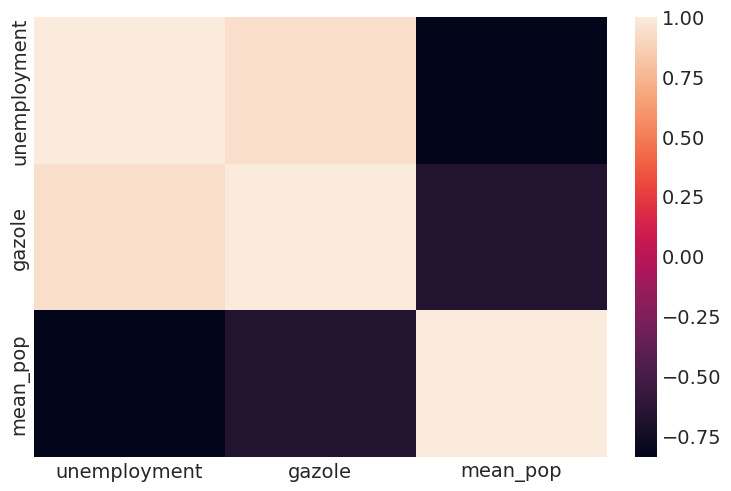

In [129]:
sns.heatmap(mb.campaign_preds.corr());

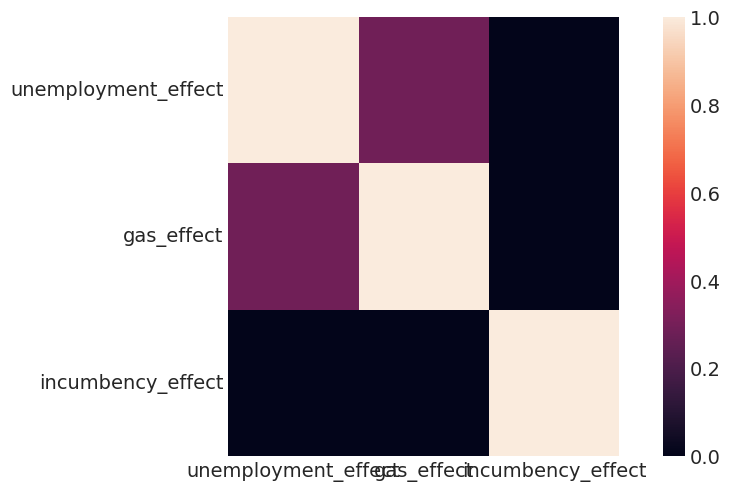

In [120]:
sns.heatmap(
    idata_hierarchical_dm.posterior[
        [
            "unemployment_effect",
            "gas_effect",
            "incumbency_effect",
        ]
    ]
    .to_dataframe()
    .corr()
);

In [130]:
idata_hierarchical_dm = mb.sample_all(
    tune=500,
    draws=500,
    var_names=[
        "latent_popularity",
        "latent_pop_t0",
        "R",
        "noisy_popularity",
        "N_approve",
    ],
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [concentration, election_party_time_coefs, party_time_coefs_raw, lsd_election_party_raw, lsd_election_party_sd, lsd_election_effect, lsd_party_effect_2, lsd_party_effect_1, lsd_intercept, incumbency_unemployment_effect, incumbency_gas_effect, incumbency_popularity_effect, incumbency_effect, popularity_effect, gas_effect, unemployment_effect, house_election_effects_raw, house_election_effect_sd, house_effects, election_party_intercept, election_party_intercept_sd, party_intercept]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 417 seconds.
The number of effective samples is smaller than 25% for some parameters.


/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/plots/traceplot.py:206: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (23), generating only 20 plots
  warnings.warn(


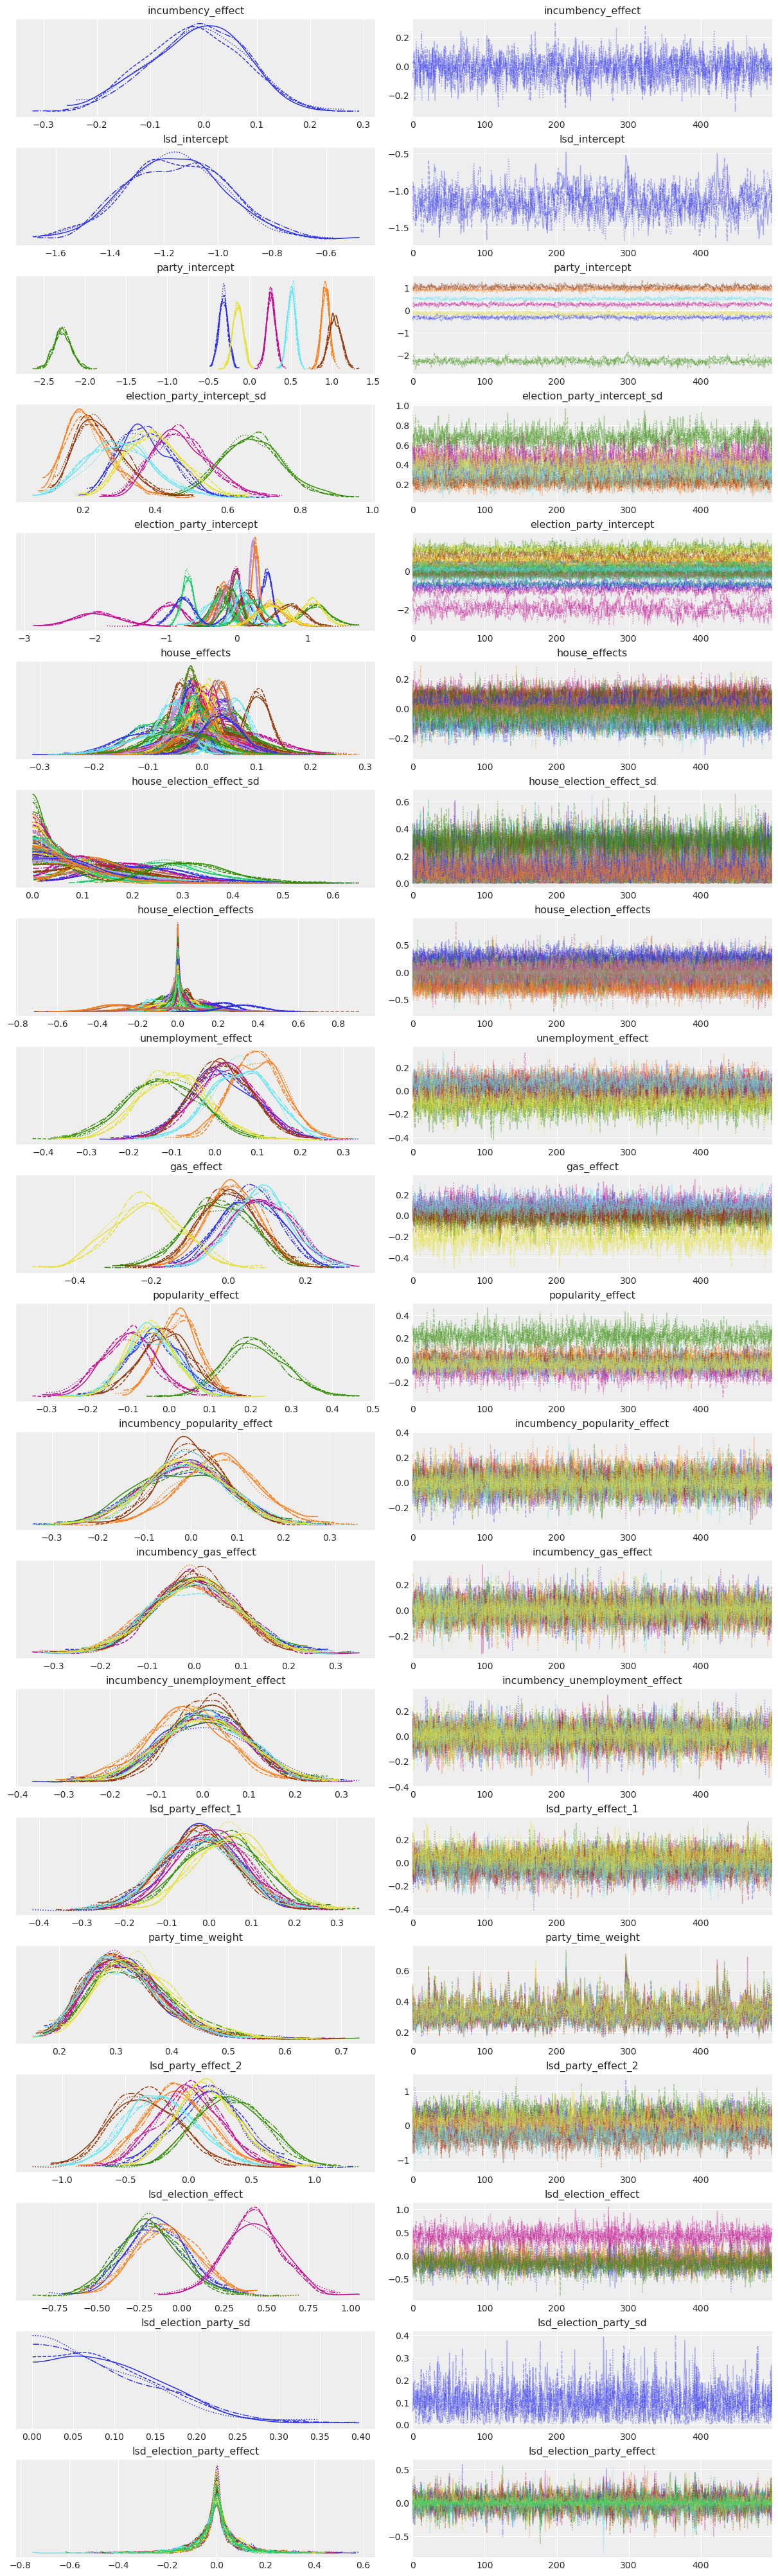

In [131]:
arviz.plot_trace(
    idata_hierarchical_dm,
    var_names=[
        "~time_effect",
        "~time_coefs",
        "~latent_popularity",
        "~noisy_popularity",
        "~raw",
    ],
    filter_vars="regex",
);

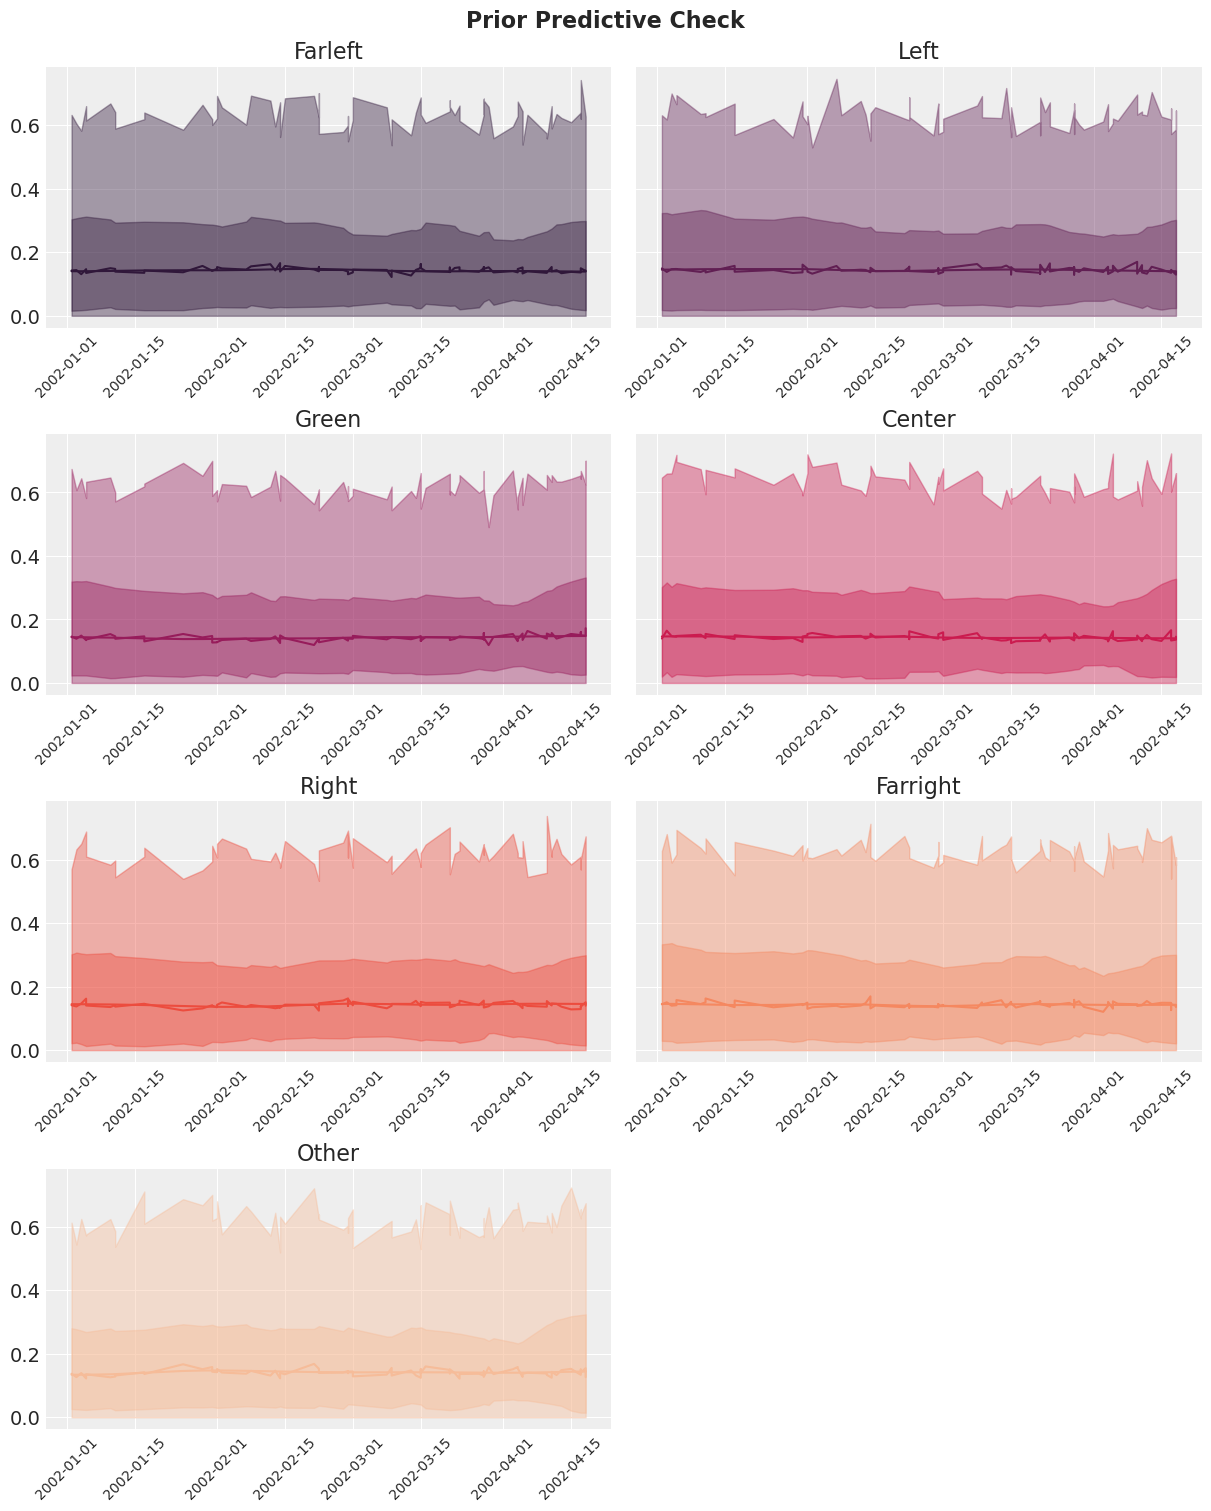

In [63]:
retrodictive_plot(
    idata_hierarchical_dm.sel(
        elections="2002-04-21",
        observations=polls_train[polls_train.dateelection == "2002-04-21"].index,
    ),
    PARTIES_COMPLETE,
    polls_train[polls_train.dateelection == "2002-04-21"],
    group="prior",
)

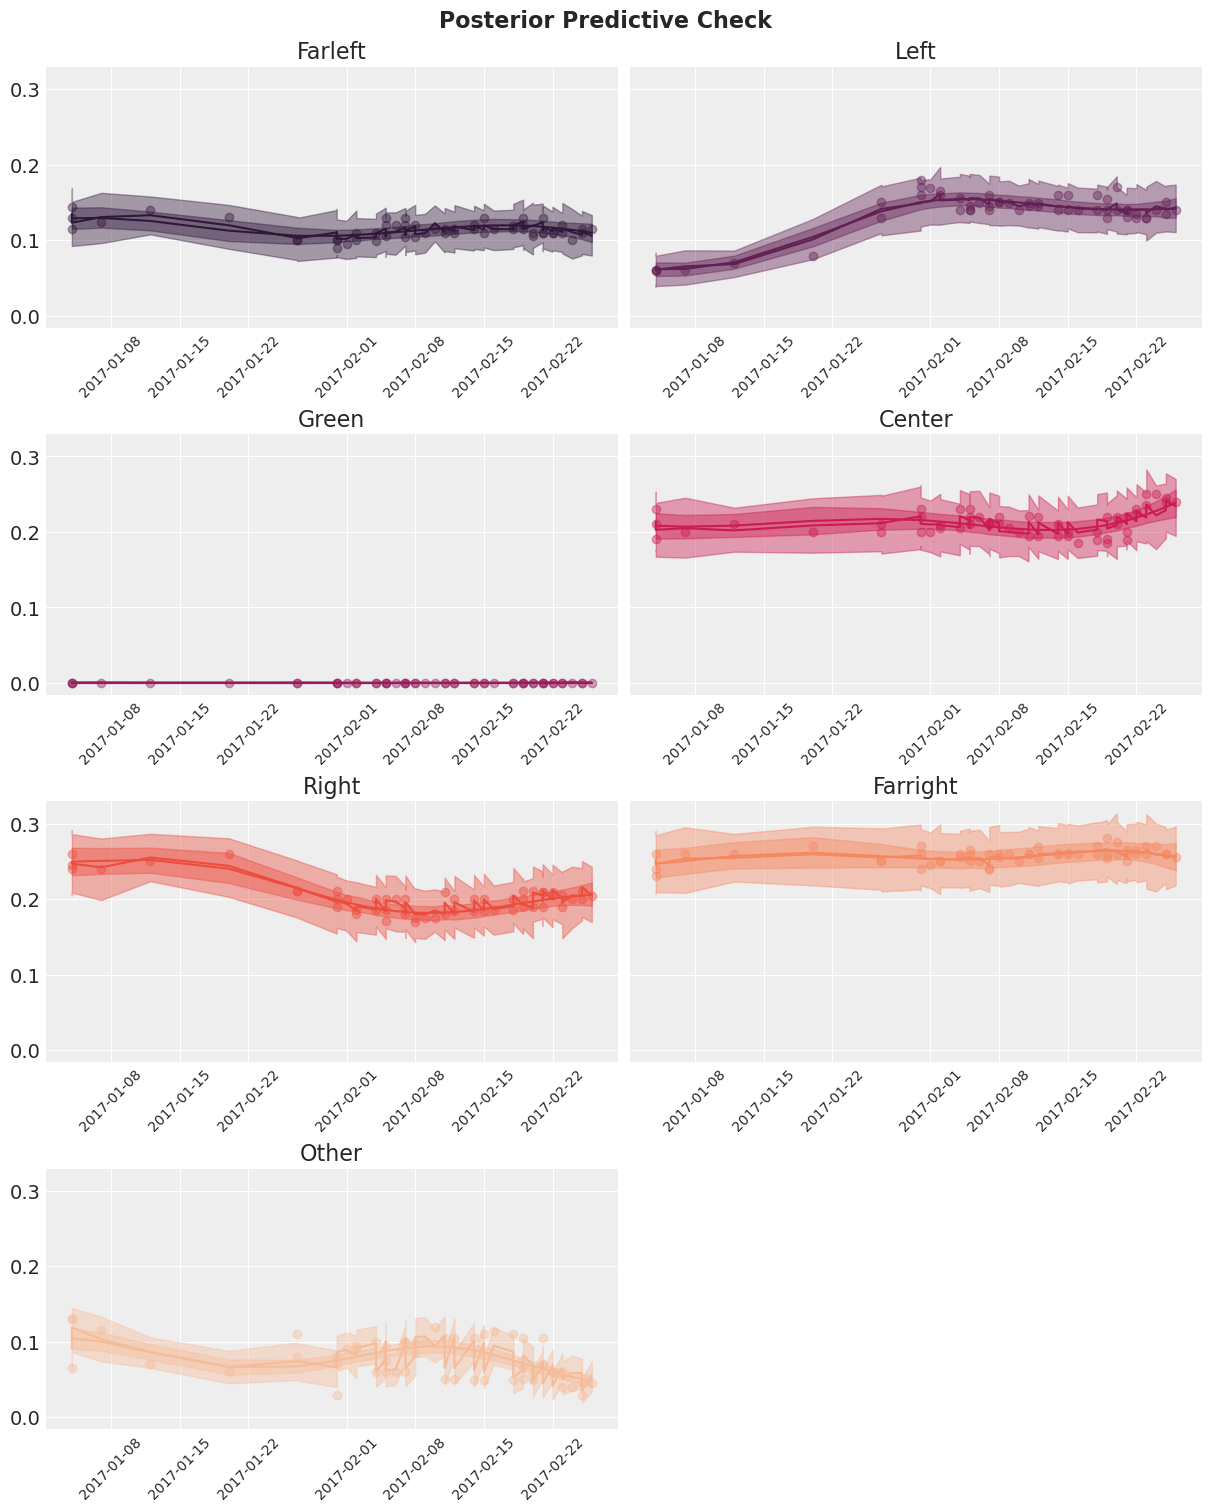

In [48]:
election_date = "2017-04-23"
polls_train = mb.polls_train.copy()
retrodictive_plot(
    idata_hierarchical_dm.sel(
        elections=election_date,
        observations=polls_train[polls_train.dateelection == election_date].index,
    ),
    mb.parties_complete,
    polls_train[polls_train.dateelection == election_date],
    group="posterior",
)

In [8]:
election_forecast = mb.forecast_election(idata_hierarchical_dm)

In [59]:
polls_train.dateelection.unique()

array(['2002-04-21T00:00:00.000000000', '2007-04-22T00:00:00.000000000',
       '2012-04-22T00:00:00.000000000', '2017-04-23T00:00:00.000000000'],
      dtype='datetime64[ns]')

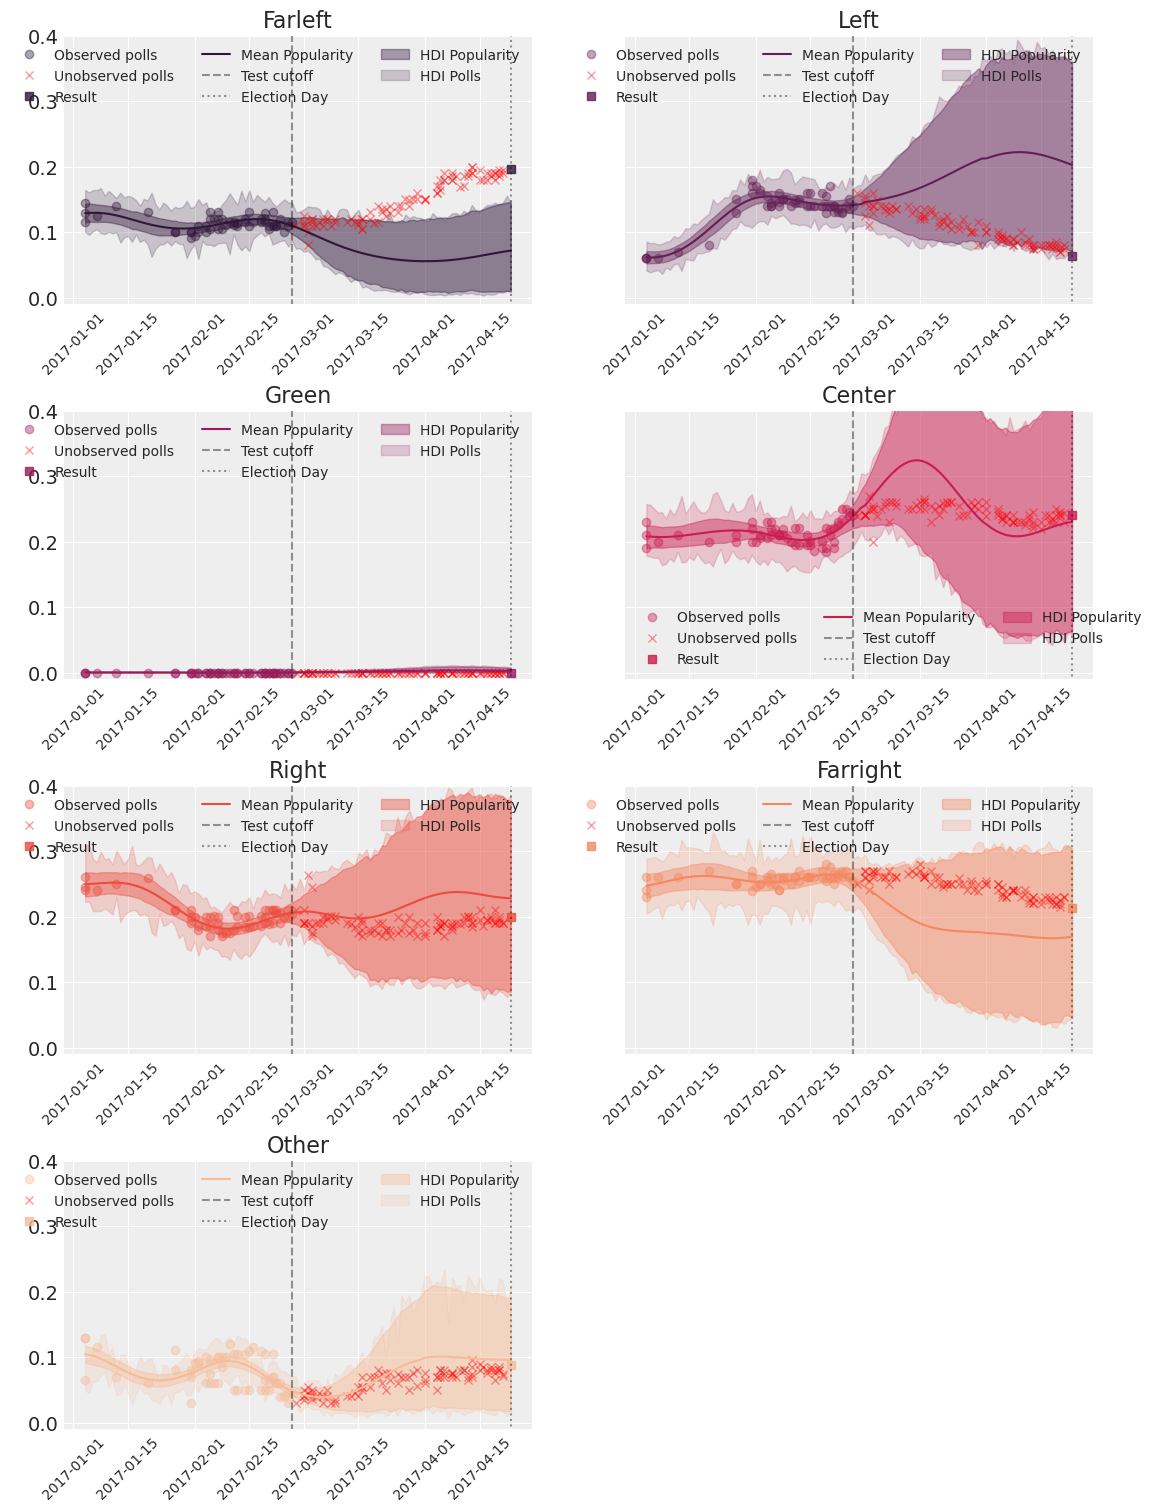

In [9]:
election_date = "2017-04-23"
results = mb.results_raw
polls_test = mb.polls_test

predictive_plot(
    election_forecast,
    mb.parties_complete,
    election_date,
    results[results.dateelection == election_date],
    polls_train[polls_train.dateelection == election_date],
    polls_test[polls_test.dateelection == election_date],
    TEST_CUTOFF,
)
# plt.savefig("ppc.png")

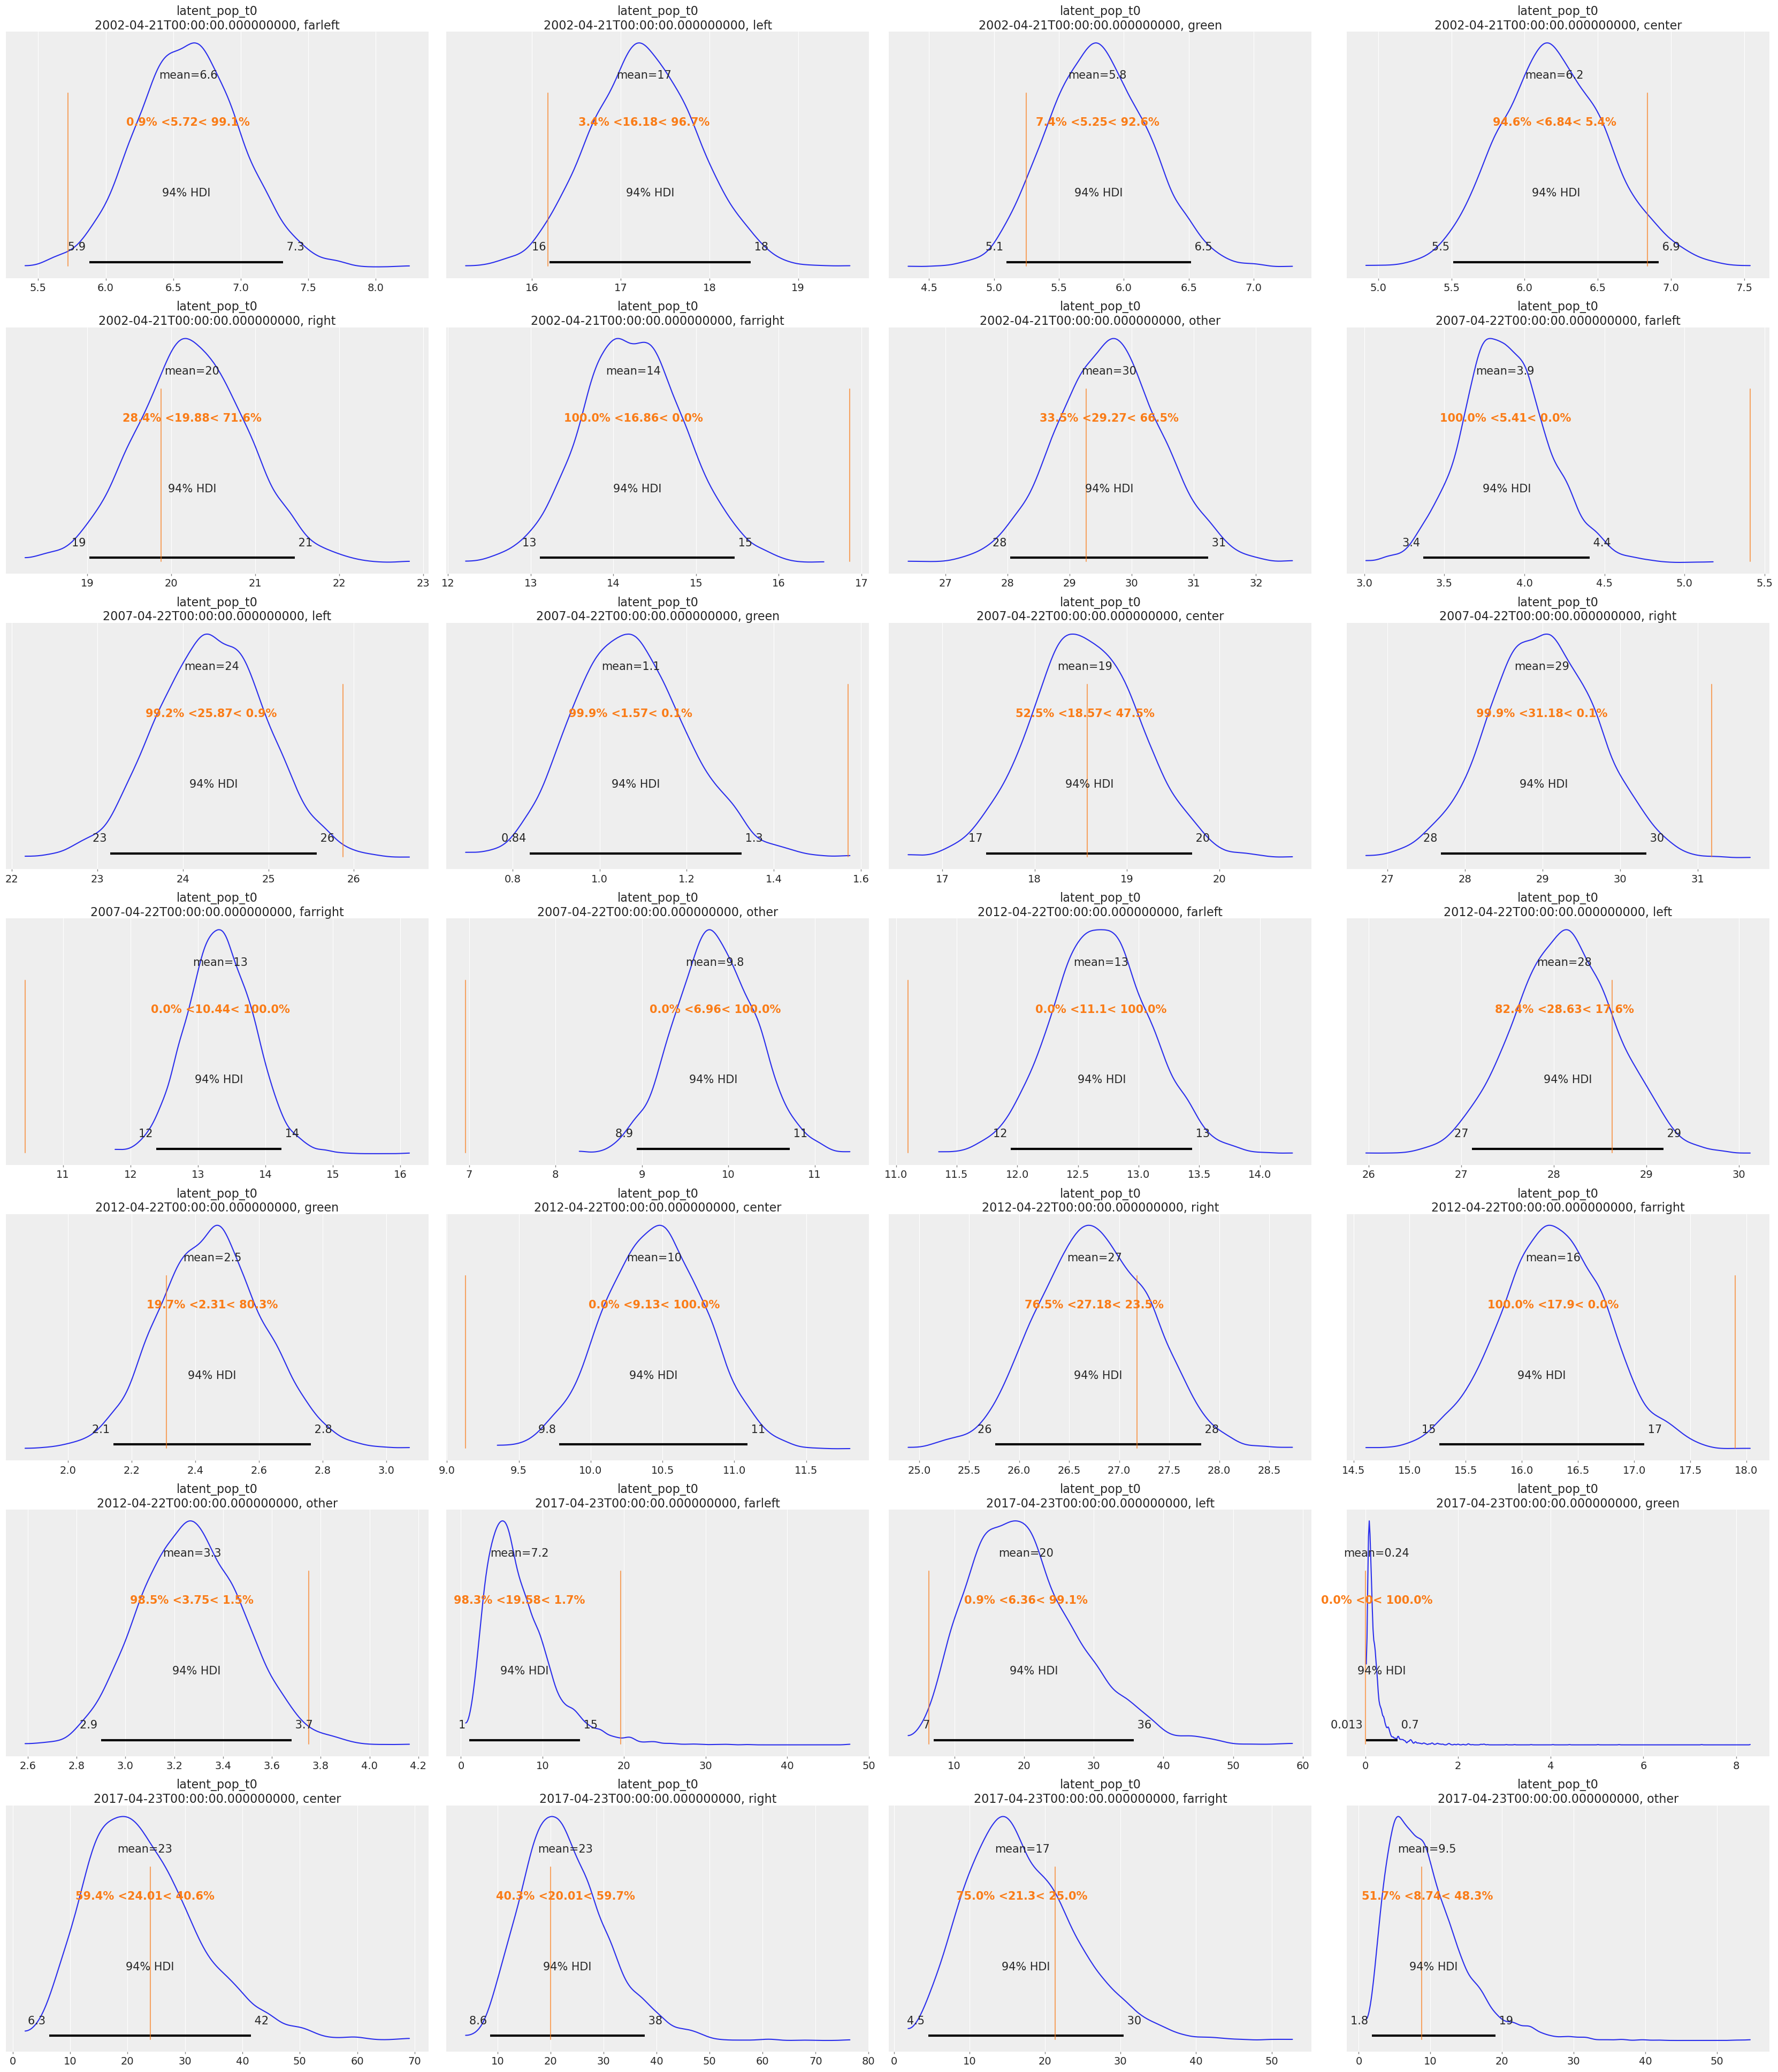

In [10]:
arviz.plot_posterior(
    election_forecast.predictions["latent_pop_t0"] * 100,
    ref_val=results[mb.parties_complete].to_numpy().flatten().tolist(),
);

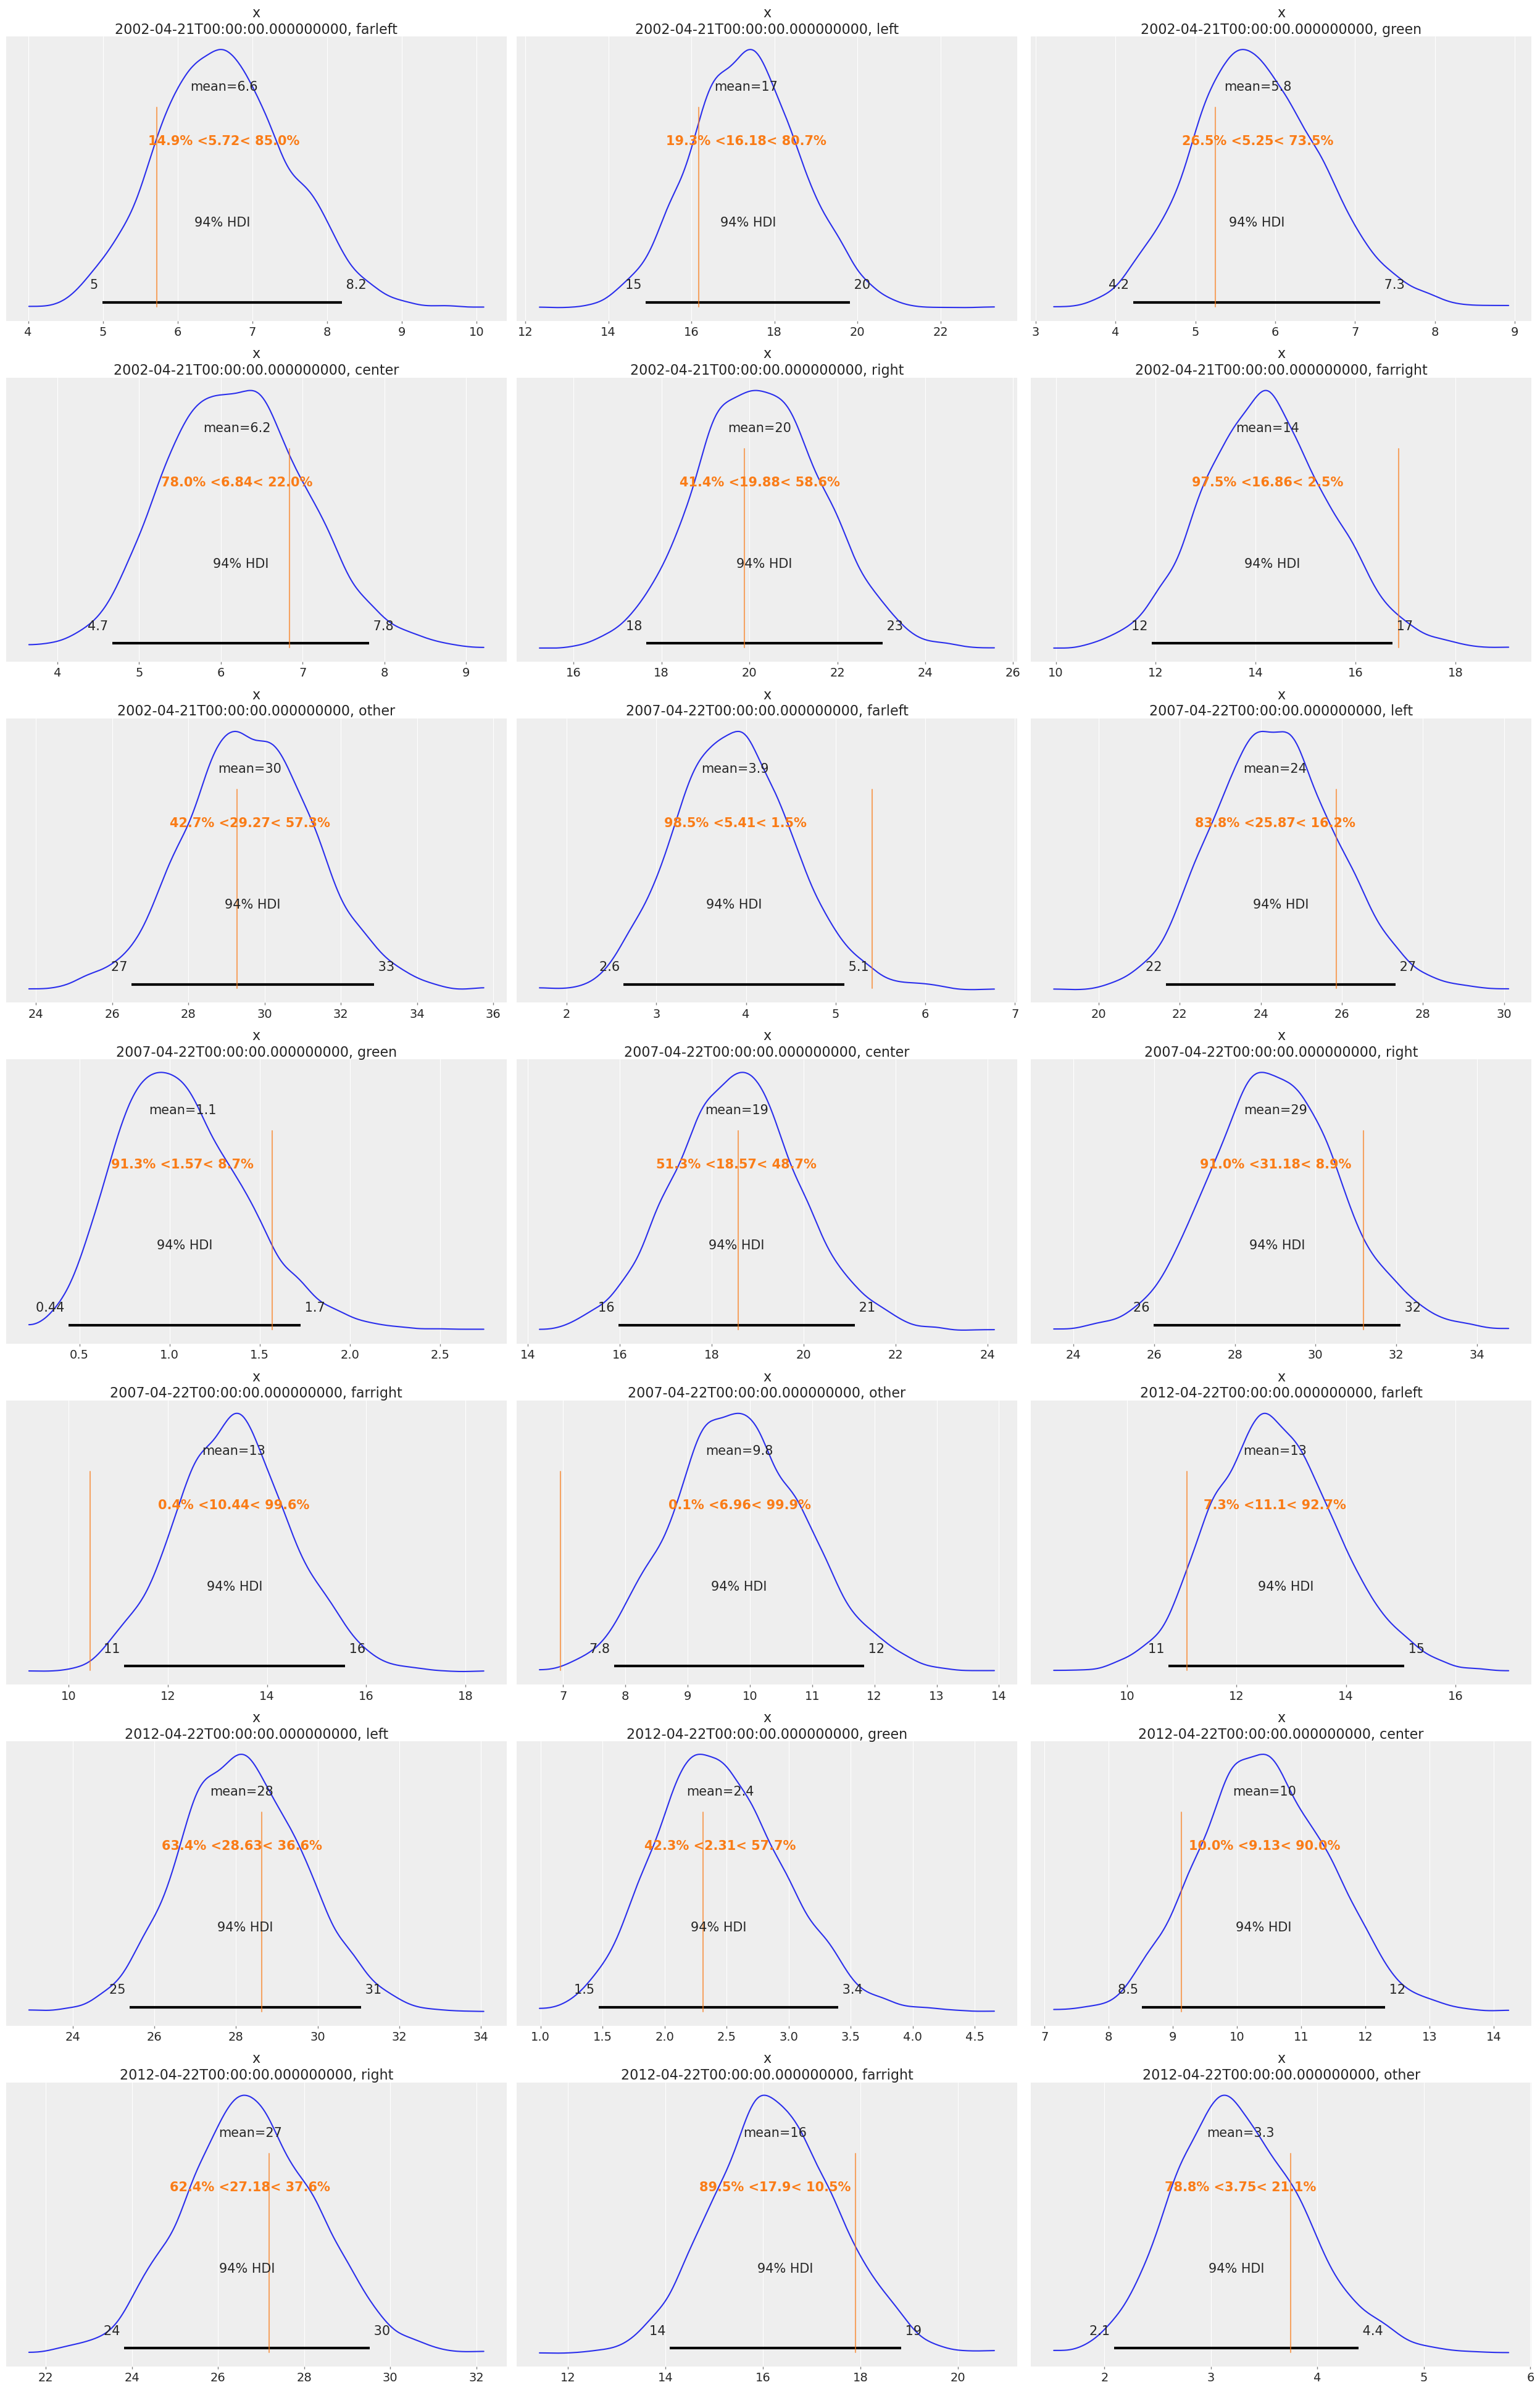

In [11]:
arviz.plot_posterior(
    (
        election_forecast.predictions["R"]
        / election_forecast.predictions_constant_data["results_N"]
    )
    * 100,
    ref_val=results[mb.parties_complete].to_numpy().flatten().tolist(),
)
# plt.savefig("ppc_results.png");

### Add predictors

In [19]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/pollsposition/data/main/predicteurs/inflation_nat_mois.csv",
    sep=";",
    skiprows=3,
).iloc[:, [0, 1]]
data.columns = ["date", "inflation"]
data = data.sort_values("date")

data.index = pd.period_range(start=data.date.iloc[0], periods=len(data), freq="M")
data.drop("date", axis=1)

inflation
1991-01        4.0
1991-02        4.0
1991-03        3.9
1991-04        3.9
1991-05        3.9
...            ...
2021-05        0.9
2021-06        1.1
2021-07        0.4
2021-08        1.5
2021-09        1.3

[369 rows x 1 columns]

In [12]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/pollsposition/data/main/predicteurs/gazole_nat_mois.csv",
    sep=";",
    skiprows=3,
).iloc[:, [0, 1]]
unemp.columns = ["date", "unemployment"]
unemp = unemp.sort_values("date")

# as timestamps variables:
unemp.index = pd.period_range(start=unemp.date.iloc[0], periods=len(unemp), freq="Q")
unemp = unemp.drop("date", axis=1)

In [13]:
# add quarters to polls data
polls_train.index = pd.DatetimeIndex(polls_train["date"].values).to_period("Q")
polls_test.index = pd.DatetimeIndex(polls_test["date"].values).to_period("Q")
results_mult.index = pd.DatetimeIndex(results_mult["date"].values).to_period("Q")

In [14]:
# merge with unemployment:
polls_train = polls_train.join(unemp).reset_index(drop=True)
polls_test = polls_test.join(unemp).reset_index(drop=True)
results_mult = results_mult.join(unemp).reset_index(drop=True)


# https://nbviewer.org/github/pollsposition/models/blob/master/district-level/munic_model_prod.ipynb

In [12]:
mb.polls_train

date     sondage dateelection  countdown  samplesize  farleft  left  \
0   2002-01-02         BVA   2002-04-21        109         919       64   221   
1   2002-01-03         CSA   2002-04-21        108         997       50   214   
2   2002-01-04       Ipsos   2002-04-21        107        5297      318  1218   
3   2002-01-05         BVA   2002-04-21        106         500       35   120   
4   2002-01-05      Kantar   2002-04-21        106         763       53   183   
..         ...         ...          ...        ...         ...      ...   ...   
341 2017-02-23       Odoxa   2017-04-23         59         884      106   115   
342 2017-02-24      Kantar   2017-04-23         58         700       70    98   
343 2017-02-25        Ifop   2017-04-23         57        1200      138   162   
344 2017-02-25  OpinionWay   2017-04-23         57        1038      114   156   
345 2017-02-26        Ifop   2017-04-23         56        1192      137   167   

     green  center  right  farright  other  unemployment president  mean_pop  
0       64      46    193        92    239           7.5   chirac1  0.532500  
1       60      40    279       100    254           7.5   chirac1  0.532500  
2      265     212   1483       477   1324           7.5   chirac1  0.532500  
3       35      15    135        45    115           7.5   chirac1  0.532500  
4       46      23    206        69    183           7.5   chirac1  0.532500  
..     ...     ...    ...       ...    ...           ...       ...       ...  
341      0     221    168       239     35           9.3  hollande  0.193338  
342      0     175    140       189     28           9.3  hollande  0.193338  
343      0     294    240       312     54           9.3  hollande  0.193338  
344      0     249    218       270     31           9.3  hollande  0.193338  
345      0     286    244       304     54           9.3  hollande  0.193338  

[346 rows x 15 columns]

#### Standardize continous predictors

In [19]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [20]:
cont_preds = (
    pd.concat(
        [
            polls_train[["date", "unemployment", "mean_pop"]],
            results_mult[["date", "unemployment", "mean_pop"]],
        ]
    )
    .set_index("date")
    .sort_index()
)
cont_preds_stdz = standardize(cont_preds)

In [21]:
results_preds = cont_preds_stdz.loc[UNIQUE_ELECTIONS]
campaign_preds = cont_preds_stdz.loc[cont_preds.index.difference(UNIQUE_ELECTIONS)]
results_oos = results_mult[results_mult.dateelection != "2017-04-23"].copy()

In [26]:
# covarying GP (transition matrix)

In [ ]:
# https://www.itl.nist.gov/div898/handbook/eda/section3/qqplot.htm
# add other election types (https://github.com/pollsposition/models/blob/master/district-level/munic_model_prod.ipynb)